In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import json
import numpy as np

## Price Data

In [350]:
files = glob.glob("../data/prices/*")

In [351]:
files

['../data/prices/prices_XBTMYR_0814.json',
 '../data/prices/prices_MATICMYR.json',
 '../data/prices/prices_XBTMYR_0813.json',
 '../data/prices/prices_ETHMYR.json']

In [352]:
prices = [json.loads(line[:-2]) for line in open(files[1], 'r')]

In [353]:
df = pd.DataFrame(prices)
df['ts'] = pd.to_datetime(df['ts'], unit = 'ms')
df = df.set_index('ts')

In [355]:
df['volatility'] = np.where(df['volatility']=="None", np.nan, df['volatility'])

In [356]:
for col in ["mid_price","spread","best_bid","best_ask","best_bid_size","best_ask_size","vamp","order_imbalance","volatility"]:
    df[col] = pd.to_numeric(df[col])

Text(0.5, 1.0, 'Volatility')

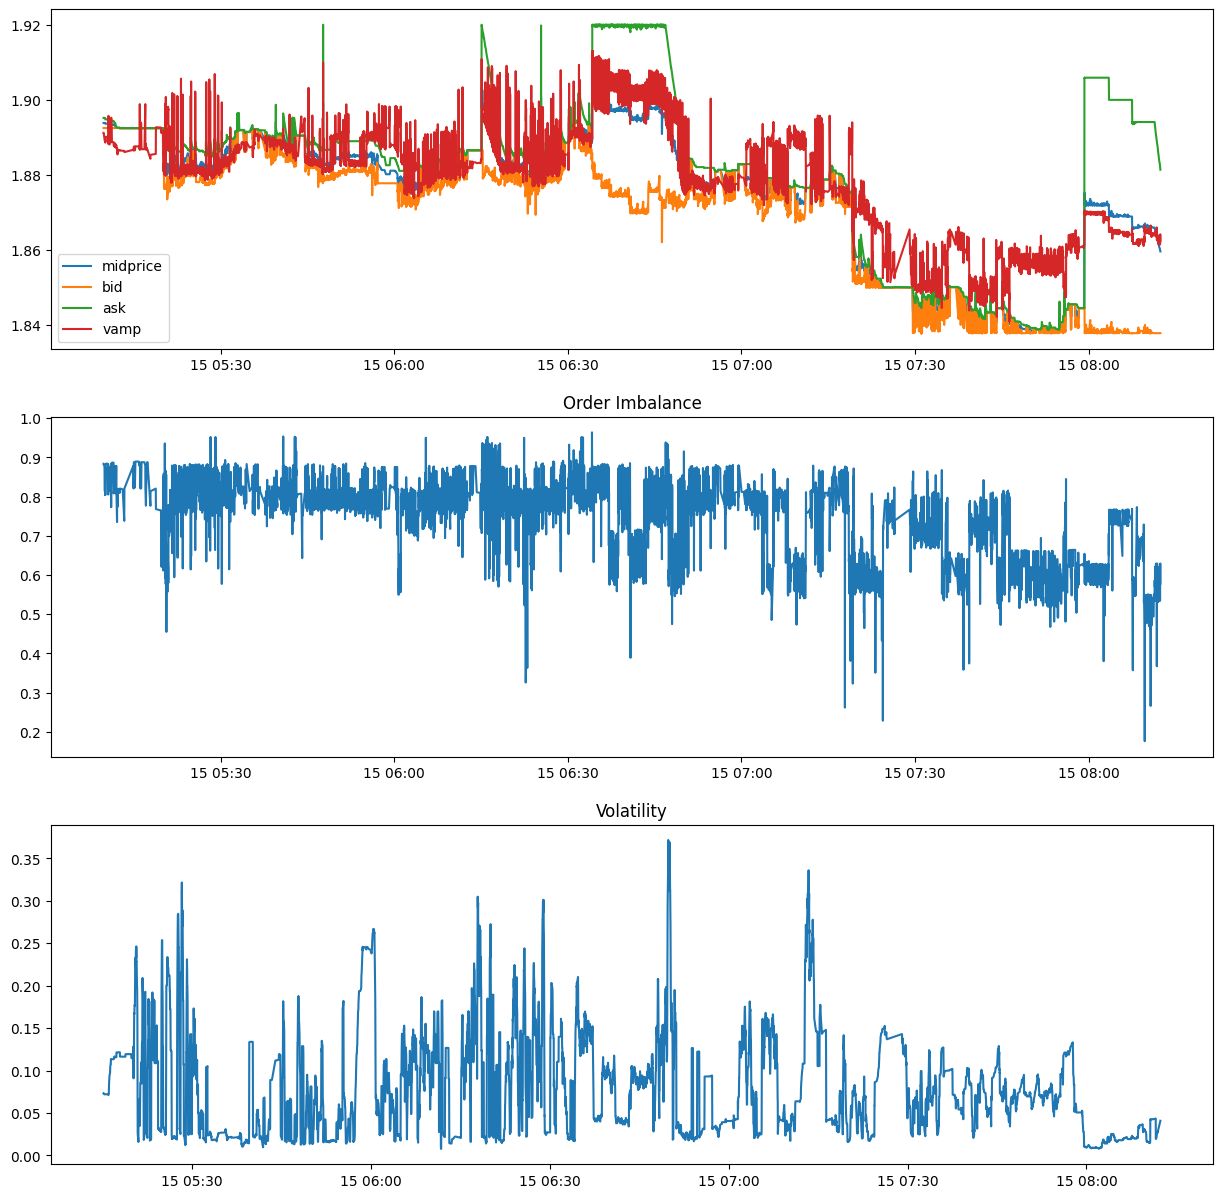

In [392]:
fig, (ax1,ax2, ax3) = plt.subplots(3,1, figsize = (15,15))
ax1.plot(df.mid_price,label="midprice")
ax1.plot(df.best_bid, label = "bid")
ax1.plot(df.best_ask, label ="ask")
ax1.plot(df.vamp, label = "vamp")
ax1.legend()
ax2.plot(df.order_imbalance)
ax2.set_title("Order Imbalance")
ax3.plot(df.volatility)
ax3.set_title("Volatility")

## Microstructure of Market Orders

In [393]:
glob.glob("../data/trades/*")

['../data/trades/trades_XBTMYR_0814.json',
 '../data/trades/trades_XBTMYR_0813.json',
 '../data/trades/trades_ETHMYR.json',
 '../data/trades/trades_MATICMYR.json']

In [394]:
trades = pd.DataFrame([json.loads(line[:-2]) for line in open(glob.glob("../data/trades/*")[3], 'r')])

In [395]:
trades.amount.min(),trades.amount.max()

(0.1, 2902.13)

In [396]:
for col in ['price','amount']:
    trades[col] = pd.to_numeric(trades[col])

### Arrival time

### CDF

$PnL * P[\text{Filled in the next trade}]$

$PnL_{buy} = Distance_{buy} - fee$

$PnL_{sell} = Distance_{sell} - fee$

Reference: https://www.vertoxquant.com/p/an-improved-market-making-strategy?utm_source=publication-search 

In [397]:
buy_trades = trades.loc[trades['bidask']=="bid"]
sell_trades = trades.loc[trades['bidask']=="ask"]

In [398]:
buy_cdf = []
sell_cdf = []
range = np.arange(0.1, 2900,0.1)
for size in range:
    filtered_buy_trades = buy_trades[buy_trades['amount'] >= size]
    filtered_sell_trades = sell_trades[sell_trades['amount'] >= size]

    buy_cdf.append(len(filtered_buy_trades)/len(buy_trades))
    sell_cdf.append(len(filtered_sell_trades)/len(sell_trades))


In [399]:
CDF = pd.DataFrame({'Buy':buy_cdf, 'Sell':sell_cdf}, index=range)

Text(0, 0.5, 'probability')

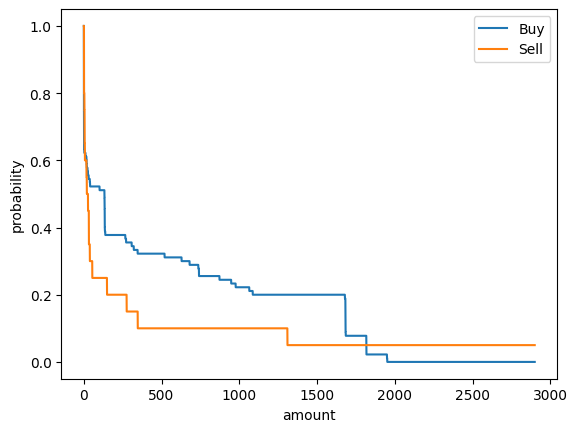

In [400]:
CDF.plot()
plt.xlabel('amount')
plt.ylabel('probability')

### Poisson process

Poisson intensity $\lambda(\delta)=Aexp(-k\delta)$

where $\delta$ = distance of the MM quote to the mid-price

We will fit the distance of the trade to midprice against amount.

Reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

In [401]:
from scipy.optimize import curve_fit
from scipy.optimize import OptimizeWarning

In [402]:
sorted_trades = trades.groupby('distance').agg({'amount':'sum'}).reset_index().sort_values('distance')

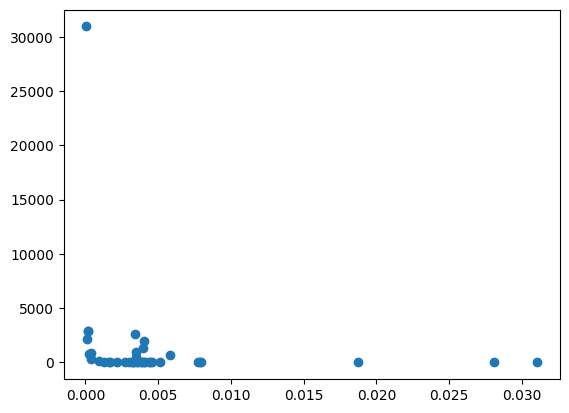

In [403]:
plt.scatter(sorted_trades.distance, sorted_trades.amount)

In [404]:
params = curve_fit(lambda t, a,b: a*np.exp(-b*t), 
                   sorted_trades['distance'].to_list(), 
                   sorted_trades['amount'].to_list(),
                   p0 = (0,0),
                   method = "dogbox", 
                   bounds = ([0,0], [np.inf, np.inf]))

In [405]:
alpha, kappa = params[0]
alpha,kappa

(355239.96455310885, 48819.59550036389)

(0.0, 0.001)

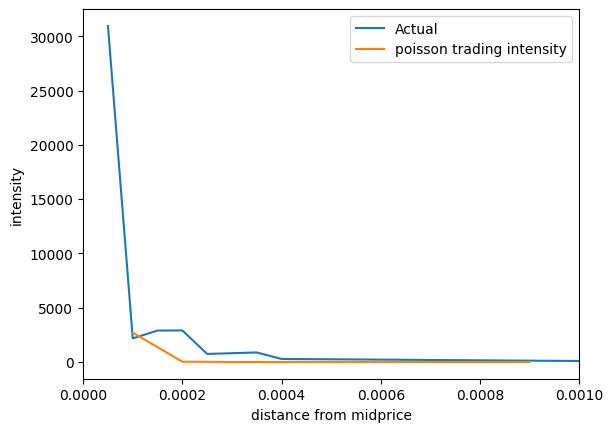

In [408]:
distance = np.arange(0.0001, 0.001, 0.0001)
plt.ylabel('intensity')
plt.xlabel('distance from midprice')
plt.plot(sorted_trades.distance, sorted_trades.amount, label = "Actual")
plt.plot(distance, alpha*np.exp(-distance*kappa), label = "poisson trading intensity")
plt.legend()
plt.xlim([0,0.001])

In [413]:
(295000.0012 // 0.001) * 0.001

295000.001